In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args
import seaborn as sns 
import matplotlib.pyplot as plt

In [4]:
import numpy as np
Skin_data = np.load('SFA_Filter_S.npy')
NonSkin_data=np.load('SFA_Filter_NS.npy')

In [5]:
input_data=[]
for i in range(2):
    if i == 0:
        for j in range(len(NonSkin_data)):
            input_data.append(NonSkin_data[j])
    else :
        for j in range(len(Skin_data)):
            input_data.append(Skin_data[j])

In [6]:
label=[]
for i in range(len(NonSkin_data)+len(Skin_data)):
    if i>len(NonSkin_data):
        label.append(0)
    else:
        label.append(1)

In [7]:
label=np.array(label)
input_data=np.array(input_data)

In [8]:
input_data= (input_data*(1/256)-0.5)/0.5

In [9]:
input_data.shape

(1753024, 9, 5)

In [10]:
input_data=torch.FloatTensor(input_data)
label=torch.LongTensor(label)

In [11]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
dataset = TensorDataset(input_data,label)

In [12]:
trainset,valset=torch.utils.data.random_split(dataset,[1403024,350000])
trainset,testset=torch.utils.data.random_split(trainset,[1053024,350000])

partition={'train':trainset,'val':valset,'test':testset}

In [31]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
class GCN(nn.Module):
    def __init__(self):
        super(GCN,self).__init__()
        A = [[1, 1, 0, 1, 1, 0, 0, 0, 0],
             [1, 1, 1, 1, 1, 1, 0, 0, 0],
             [0 ,1, 1, 0, 1, 1, 0, 0, 0],
             [1, 1, 0, 1, 1, 0, 1, 1, 0],
             [1, 1, 1, 1, 1, 1, 1, 1, 1],
             [0, 1, 1, 0, 1, 1, 0, 1, 1],
             [0, 0, 0, 1, 1, 0, 1, 1, 0],
             [0, 0, 0, 1, 1, 1, 1, 1, 1],
             [0, 0, 0, 0, 1, 1, 0, 1, 1]]
        adj=torch.FloatTensor(A)
        adj=adj.cuda()
        self.adj=adj
        self.W= nn.Parameter(torch.detach(torch.rand(5,10)).requires_grad_(True))
        self.W1= nn.Parameter(torch.detach(torch.rand(10,20)).requires_grad_(True))#hid_dim이라 생각하면 편함
        self.W2= nn.Parameter(torch.detach(torch.rand(20,40)).requires_grad_(True))
        self.act = nn.Sigmoid()
        self.Linear=nn.Linear(40,1)
        self.Linear1=nn.Linear(9,2)
        
    def forward(self,x):
        outs=[]
        out = torch.matmul(x,self.W)
        out = self.act(out)
        out = torch.matmul(self.adj,out)
        out = torch.matmul(out,self.W1)
        out = self.act(out)
        out = torch.matmul(self.adj,out)
        out = torch.matmul(out,self.W2)
        out = self.act(out)
        out = torch.matmul(self.adj,out)
        
        mic1,mic2,mic3,mic4,mic5,mic6,mic7,mic8,mic9=torch.chunk(out,9,-2)
        #print(mic1,mic1.shape)
        x1= self.Linear(mic1)
        x2= self.Linear(mic2)
        x3= self.Linear(mic3)
        x4= self.Linear(mic4)
        x5= self.Linear(mic5)
        x6= self.Linear(mic6)
        x7= self.Linear(mic7)
        x8= self.Linear(mic8)
        x9= self.Linear(mic9)
        out1=torch.cat([x1,x2,x3,x4,x5,x6,x7,x8,x9],1)
        out1=torch.squeeze(out1)
        out1=self.act(out1)
        out1 =self.Linear1(out1)
        return out1

In [24]:
def dimension_check():
    net=GCN()
    net=net.cuda()
    x= torch.randn(9,5)
    x=x.cuda()
    y=net(x)
    print(y,x)

In [25]:
dimension_check()

tensor([ 0.2141, -0.2151], device='cuda:0', grad_fn=<AddBackward0>) tensor([[ 0.0315, -0.0933,  1.5692, -1.4407, -0.2818],
        [-1.4996, -1.2717,  1.1513, -0.7551, -2.0384],
        [-0.9043, -0.7044,  0.0939, -0.7256,  0.8395],
        [-0.8723,  0.4066, -0.3019,  1.0551,  0.8024],
        [ 1.9697,  1.9045,  0.0928, -1.6816,  0.8888],
        [-0.5905,  0.5722, -0.2839,  1.1069, -0.3026],
        [-0.3728,  1.7021, -0.1753, -0.9340, -0.3730],
        [ 0.0710, -0.7039, -0.6509,  0.8589, -0.6979],
        [ 0.1460, -1.1682, -2.1898,  0.6291,  1.0272]], device='cuda:0')


In [26]:
def train(net,partition,optimizer,creiterion):
    trainloader = torch.utils.data.DataLoader(partition['train'],
                                             batch_size=4096,
                                             shuffle=True)
    net.train()
    correct = 0
    total =0
    train_loss = 0.0
    for i, data in enumerate(tqdm(trainloader, 0)):
        time.sleep(0.0000001)
        optimizer.zero_grad()
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)
        #break
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        #if i % 200 == 0:
        #    print(correct,train_loss)
    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [27]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=4096, 
                                             shuffle=False, num_workers=2)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(testloader):
            time.sleep(0.0000001)
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [28]:
def validate(net, partition, criterion):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=4096, 
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in tqdm(valloader):
            time.sleep(0.0000001)
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [29]:
from tqdm import tqdm, tqdm_notebook
from tqdm import trange
import time

In [32]:
net=GCN()
net.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0015, weight_decay=0.00001)
train_losses=[]
val_losses=[]
train_accs=[]
val_accs=[]
for epoch in range(20):
    ts=time.time()
    net, train_loss,train_acc=train(net, partition, optimizer, criterion)
    val_loss, val_acc = validate(net, partition, criterion)
    te=time.time()
    print('time : {:2.2f}, train_loss : {:2.2f}, train_acc : {:2.2f},val_acc : {:2.2f},val_loss : {:2.2f}'.format(te-ts,train_loss,train_acc,val_acc,val_loss))
    
    train_loss=round(train_loss,2)#리스트에 넣기 위해 3번째 자릿수 반올림
    val_loss=round(val_loss,2)
    train_acc=round(train_acc,2)
    val_acc=round(val_acc,2)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)    


  0%|          | 1/258 [00:00<00:34,  7.40it/s]

time : 12.23, train_loss : 0.67, train_acc : 60.80,val_acc : 62.53,val_loss : 0.66


  1%|          | 2/258 [00:00<00:18, 14.18it/s]

time : 11.97, train_loss : 0.66, train_acc : 62.46,val_acc : 62.53,val_loss : 0.66


  1%|          | 2/258 [00:00<00:21, 11.90it/s]

time : 12.19, train_loss : 0.64, train_acc : 64.57,val_acc : 82.55,val_loss : 0.41


  1%|          | 2/258 [00:00<00:14, 17.52it/s]

time : 12.20, train_loss : 0.29, train_acc : 89.31,val_acc : 92.65,val_loss : 0.22


  1%|          | 2/258 [00:00<00:23, 10.93it/s]

time : 12.23, train_loss : 0.21, train_acc : 92.64,val_acc : 92.70,val_loss : 0.20


  0%|          | 1/258 [00:00<00:26,  9.78it/s]

time : 11.92, train_loss : 0.20, train_acc : 92.87,val_acc : 92.80,val_loss : 0.20


  1%|          | 2/258 [00:00<00:14, 17.88it/s]

time : 12.00, train_loss : 0.20, train_acc : 93.00,val_acc : 93.29,val_loss : 0.19


  1%|          | 2/258 [00:00<00:18, 14.21it/s]

time : 12.32, train_loss : 0.19, train_acc : 93.31,val_acc : 93.27,val_loss : 0.18


  1%|          | 2/258 [00:00<00:13, 18.55it/s]

time : 11.78, train_loss : 0.18, train_acc : 93.42,val_acc : 93.57,val_loss : 0.18


  0%|          | 1/258 [00:00<00:32,  7.91it/s]

time : 12.14, train_loss : 0.18, train_acc : 93.48,val_acc : 93.60,val_loss : 0.18


  1%|          | 2/258 [00:00<00:14, 17.83it/s]

time : 12.04, train_loss : 0.18, train_acc : 93.53,val_acc : 93.50,val_loss : 0.18


  0%|          | 1/258 [00:00<00:39,  6.43it/s]

time : 12.10, train_loss : 0.18, train_acc : 93.57,val_acc : 93.52,val_loss : 0.18


  1%|          | 2/258 [00:00<00:14, 17.62it/s]

time : 12.15, train_loss : 0.18, train_acc : 93.65,val_acc : 93.53,val_loss : 0.18


  0%|          | 1/258 [00:00<00:34,  7.51it/s]

time : 12.24, train_loss : 0.17, train_acc : 93.74,val_acc : 93.82,val_loss : 0.17


  1%|          | 2/258 [00:00<00:18, 14.19it/s]

time : 12.04, train_loss : 0.17, train_acc : 93.85,val_acc : 93.80,val_loss : 0.17


  1%|          | 2/258 [00:00<00:22, 11.13it/s]

time : 12.26, train_loss : 0.17, train_acc : 93.97,val_acc : 94.11,val_loss : 0.17


  1%|          | 2/258 [00:00<00:18, 14.20it/s]

time : 12.21, train_loss : 0.16, train_acc : 94.16,val_acc : 94.25,val_loss : 0.16


  1%|          | 2/258 [00:00<00:23, 10.94it/s]

time : 12.07, train_loss : 0.15, train_acc : 94.61,val_acc : 94.88,val_loss : 0.14


  1%|          | 2/258 [00:00<00:15, 16.21it/s]

time : 12.20, train_loss : 0.13, train_acc : 95.21,val_acc : 95.22,val_loss : 0.13


100%|██████████| 86/86 [00:01<00:00, 52.10it/s]

time : 12.17, train_loss : 0.13, train_acc : 95.32,val_acc : 94.59,val_loss : 0.15


In [33]:
test_acc = test(net,partition,criterion)
test_acc=round(test_acc,2)
result = {}
result['train_losses'] = train_losses
result['val_losses'] = val_losses
result['train_accs'] = train_accs
result['val_accs'] = val_accs
result['train_acc'] = train_acc
result['val_acc'] = val_acc
result['test_acc'] = test_acc


100%|██████████| 86/86 [00:01<00:00, 43.43it/s]


In [34]:
torch.save(net,'testmodel1.pt') #저장됨

#torch.save(net.state_dic(),'testmodel_state_dict.pt') #저장안됨
torch.save({
    'model' : net.state_dict(),
    'optimizer' : optimizer.state_dict()
},"all1.tar")#여러 가지 값 저장, 학습 중 진행 상황 저장을 위해 epoch,loss 값 등 일반 scalar값 저장

In [35]:
model = torch.load('testmodel1.pt')
"""
model = torch.load(PATH + 'model.pt')  # 전체 모델을 통째로 불러옴, 클래스 선언 필수
model.load_state_dict(torch.load(PATH + 'model_state_dict.pt'))  # state_dict를 불러 온 후, 모델에 저장

checkpoint = torch.load(PATH + 'all.tar')   # dict 불러오기
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
"""
model.cuda()

GCN(
  (act): Sigmoid()
  (Linear): Linear(in_features=40, out_features=1, bias=True)
  (Linear1): Linear(in_features=9, out_features=2, bias=True)
)

In [36]:
model.eval()

GCN(
  (act): Sigmoid()
  (Linear): Linear(in_features=40, out_features=1, bias=True)
  (Linear1): Linear(in_features=9, out_features=2, bias=True)
)

(180, 180, 3)

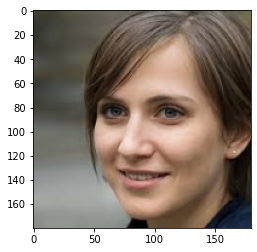

In [88]:
import cv2
img=cv2.imread("testimage.jpg")
img=cv2.resize(img,(180,180), interpolation=cv2.INTER_CUBIC)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
img.shape

In [89]:
def YCbCrTransform(x):
    #================= exponancial function ==================#
    exponancial=[[65.738, 129.057, 25.064],
                 [-37.945, -74.494, 112.439],
                 [112.439, -94.154, -18.285]]
    exponancial=np.matrix(exponancial)
    exponancial=(1/256)*exponancial
    
    A=[[16],[128],[128]]
    A=np.matrix(A)
    #=========================================================#
    x=np.matrix(x)
    x=np.transpose(x)
    Answer=A+exponancial*x
    Answer=np.array(Answer)
    Answer=Answer.tolist()
    Cb=Answer[1][0]
    Cr=Answer[2][0]
    
    return Cb,Cr
def Make_redemention(x):
    before_result=[]
    for i in range(x.shape[0]):    #x.shape[0]
        before_result1=[]
        for j in range(x.shape[1]):
            before_result2=[]
            for k in range(x.shape[2]):
                before_result3=[]
                before=x[i][j][k]
                Cb,Cr=YCbCrTransform(before)
                before_result3.append(before[0])
                before_result3.append(before[1])
                before_result3.append(before[2])
                before_result3.append(Cb)
                before_result3.append(Cr)
                before_result2.append(before_result3)
            before_result1.append(before_result2)
        before_result.append(before_result1)
    return before_result
def reshape_demension(x):
    make_result=[]
    for i in range(x.shape[0]):
        make_result1=[]
        for j in range(x.shape[1]):
            for k in range(x.shape[2]):
                make_result1.append(x[i][j][k])
        make_result.append(make_result1)
    return make_result

In [90]:
test_result=[]
for i in range(len(img)-3):
    for k in range(len(img[0])-3):
        make_data=img[i:i+3,k:k+3]
        test_result.append(make_data)

In [91]:
test_result=np.array(test_result)

In [92]:
AAA=Make_redemention(test_result)
AAA=np.array(AAA,dtype=np.uint8)
AAA1=reshape_demension(AAA)
AAA1=np.array(AAA1)
AAA1= (AAA1*(1/256)-0.5)/0.5
test_input=torch.FloatTensor(AAA1)

In [93]:
test_input.shape
result_data=[]
for i in range(len(test_input)):
    in_test_result=test_input[i]
    in_test_result=in_test_result.cuda()
    out_test=model(in_test_result)
    #print(out_test)
    _, predicted = torch.max(out_test,-1)
    #print(predicted)
    result_data.append(predicted)    

In [94]:
result_data=torch.tensor(result_data)

In [95]:
result_data=np.array(result_data)
result_data=result_data.tolist()

In [96]:
tototo=np.array(result_data)

In [97]:
result_img=[]
for i in range(len(img)-3):
    result_img1=[]
    for j in range(len(img[0])-3):
        if tototo[j+i*(len(img[0])-3)] ==0:
            result_img1.append([0,0,0])
        else:
            result_img1.append([255,255,255])
    result_img.append(result_img1)
    result_img1=[]

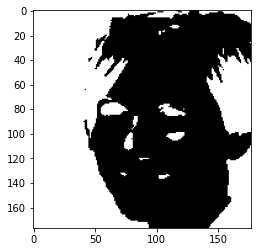

In [98]:
result_img=np.array(result_img,dtype=np.uint8)
plt.imshow(result_img)
plt.show()